##Only run this once

get libraries, install mido, mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mido

     |████████████████████████████████| 51 kB 4.5 MB/s 


In [ ]:
import mido
from mido import MidiFile
import os
import glob

import numpy as np
import pandas as pd

##Set Up Data Format


In [ ]:
def get_alpha_format(file_path):
  mid = mido.MidiFile(file_path)
  mididict = []
  alpha = []

  # Put all note on/off in midinote as dictionary.
  for i in mid:
      if i.type == 'note_on' or i.type == 'note_off' or i.type == 'time_signature':
          mididict.append(i.dict())
  # change time values from delta to relative time.
  mem1=0
  for i in mididict:
      time = i['time'] + mem1
      i['time'] = time
      mem1 = i['time']
  # make every note_on with 0 velocity note_off
      if i['type'] == 'note_on' and i['velocity'] == 0:
          i['type'] = 'note_off'
  # put note, starttime, stoptime, as nested list in a list. # format is [type, note, time, velocity]
      mem2=[]
      if i['type'] == 'note_on' or i['type'] == 'note_off':
          mem2.append(i['type'])
          mem2.append(i['note'])
          mem2.append(i['time'])
          mem2.append(i['velocity'])
          alpha.append(mem2)
  
  return alpha

##Grab file paths

Here, the "folder_path" that I am using points to where I have maestro saved on *my* drive; ya'll will have to replace it with the relevant path for you.

The **only** thing that will need to be altered is "folder_path"; leave all the other paths as-is

In [ ]:
#grab the folder paths for each year of the competition
folder_path = r'[FILE PATH TO MAESTRO DATASET]'

years = ['2018', '2017', '2015', '2014', '2013', '2011', '2009', '2008', '2006', '2004']
year_paths = []
#music_paths = np.zeros((len(year_paths), ))

for i in range(len(years)):
  year_paths.append(folder_path + '\\' + str(years[i]))

In [ ]:
#for a given year, grab all of the midi file paths within it

year_path = r'[FILE PATH TO A YEAR IN MAESTRO DATASET]' #replace w/ year_paths[i]
files = os.listdir(year_path) 
music_paths = []

for i in range(len(files)):
    music_paths.append(year_path + '/' + str(files[i]))

##Define functions for extracting each feature

In [ ]:
# Find the range of "notes at a time" for the whole song

def findMaxNotes(song):
  maxNotes = 0
  count = 0
  for i in song:
    if i[0] == 'note_on':
      count+=1
    else:
      count-=1
  
    if count > maxNotes:
      maxNotes = count  
  return (maxNotes)

In [ ]:
# This will find the average "distance" (number of notes) between
# one note and the next

def findAvgDist(song):
  note = song[0][1]
  distanceSum = 0
  numNoteOn = 0

  for i in song:
    if i[0] == 'note_on':
      numNoteOn += 1
      distanceSum += np.abs(i[1] - note)
      note = i[1]

  return distanceSum/numNoteOn

In [ ]:
# Find the average difference between note_on events

def findAvgTime(song):
  time = song[0][2]
  timeDiffSum = 0
  numNoteOn = 0

  for i in song:
    if i[0] == 'note_on':
      numNoteOn += 1
      timeDiffSum += np.abs(i[2] - time)
      time = i[2]

  return timeDiffSum/numNoteOn

In [ ]:
# Find the range of velocity

def findVelRange(song):
  velocities = []

  for i in song:
    velocities.append(i[3])

  return max(velocities)

In [ ]:
# Find the average velocity

def findVelAvg(song):
  numNoteOn = 0
  velocitySum = 0

  for i in song:
    if i[0] == 'note_on':
      numNoteOn += 1
      velocitySum += i[3]

  return velocitySum/numNoteOn

A lot of these have the same "for i in song" loop -- instead of calling a bunch of functions that run that same loop, should probably merge functions

In [ ]:
# Here's all the functions put together in a way that's much
# less readable but hopefully more efficient

def getAlphaFeatures(song):
  #max notes
  maxNotes = 0
  maxNotesCount = 0
  distanceSum = 0
  numNoteOn = 0

  #avg distance
  note = song[0][1]

  #avg time difference
  time = song[0][2]
  timeDiffSum = 0

  #maxVelocity
  maxVelocity = 0

  #avgVelocity
  velocitySum = 0

  for i in song:

    if i[0] == 'note_on':
      #find max notes
      maxNotesCount+=1

      #find average distance
      numNoteOn += 1
      distanceSum += np.abs(i[1] - note)
      note = i[1]

      #find average time difference
      timeDiffSum += np.abs(i[2] - time)
      time = i[2]

      #find average velocity
      velocitySum += i[3]

    else:
      maxNotesCount-=1
  
    if maxNotesCount > maxNotes:
      maxNotes = maxNotesCount  

    #find the max velocity
    if i[3] > maxVelocity:
      maxVelocity = i[3]

  return (maxNotes), distanceSum/numNoteOn, timeDiffSum/numNoteOn, maxVelocity, velocitySum/numNoteOn

##Define a function that grabs all of the features from a single file

In [ ]:
def single_file(file_path):
  alpha = get_alpha_format(file_path)
  #beta = get_beta_format(alpha)

  features = []
  # Features are in order: [maxNotes, avgDist, avgTime, maxVel, avgVel]

  for i in getAlphaFeatures(alpha):
    features.append(i)

  return features


# Get a sample of Debussy and Rachmaninoff

In [ ]:
df3 = pd.read_json("[FILE PATH TO MAESTRO JSON FILE]")

In [ ]:
debussy_songs = []
rachman_songs = []

for i in range(df3.shape[0]): 
  if df3['canonical_composer'][i] == "Claude Debussy":
    debussy_songs.append(df3['midi_filename'][i])

for i in range(df3.shape[0]): 
  if df3['canonical_composer'][i] == "Sergei Rachmaninoff":
    rachman_songs.append(df3['midi_filename'][i])

In [ ]:
path_prefix = '[FILE PATH TO MAESTRO DATASET]'
debussy_files = []
rachman_files = []

for i in range(len(debussy_songs)):
  debussy_files.append(path_prefix + debussy_songs[i])

for i in range(len(rachman_songs)):
  rachman_files.append(path_prefix + rachman_songs[i])

# Get features for those songs

In [ ]:
#This took 1 min to run

debussy_features = []

for i in debussy_files:
  debussy_features.append(single_file(i))

In [ ]:
rachman_features = []

for i in rachman_files:
  rachman_features.append(single_file(i))

In [ ]:
# couldn't just grab columns with lists, need to make them arrays
debussy_features = np.array(debussy_features)
rachman_features = np.array(rachman_features)

#Plot those features

In [ ]:
import matplotlib.pyplot as plt

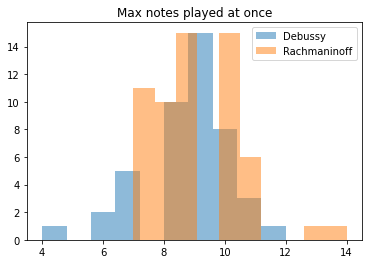

In [ ]:
plt.hist(debussy_features[:,0], alpha = 0.5, label = "Debussy")
plt.hist(rachman_features[:,0], alpha = 0.5, label = "Rachmaninoff")
plt.title("Max notes played at once")
plt.legend()
plt.show()

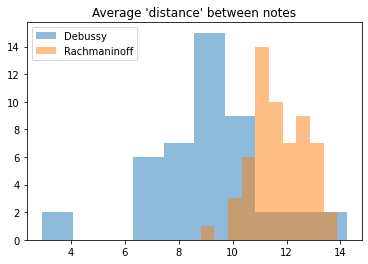

In [ ]:
plt.hist(debussy_features[:,1], alpha = 0.5, label = "Debussy")
plt.hist(rachman_features[:,1], alpha = 0.5, label = "Rachmaninoff")
plt.title("Average 'distance' between notes")
plt.legend()
plt.show()

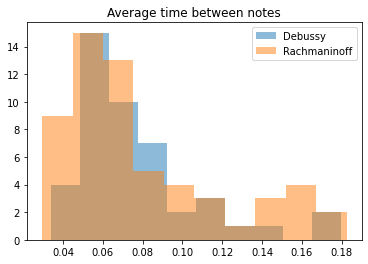

In [ ]:
plt.hist(debussy_features[:,2], alpha = 0.5, label = "Debussy")
plt.hist(rachman_features[:,2], alpha = 0.5, label = "Rachmaninoff")
plt.title("Average time between notes")
plt.legend()
plt.show()

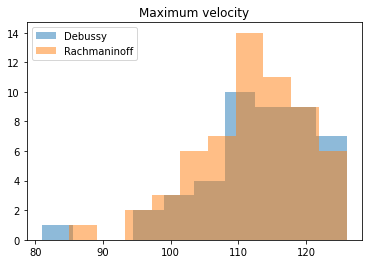

In [ ]:
plt.hist(debussy_features[:,3], alpha = 0.5, label = "Debussy")
plt.hist(rachman_features[:,3], alpha = 0.5, label = "Rachmaninoff")
plt.title("Maximum velocity")
plt.legend()
plt.show()

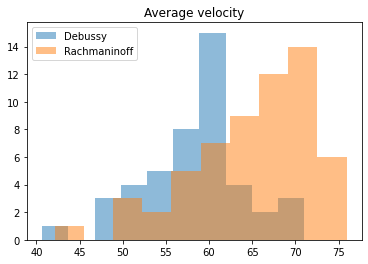

In [ ]:
plt.hist(debussy_features[:,4], alpha = 0.5, label = "Debussy")
plt.hist(rachman_features[:,4], alpha = 0.5, label = "Rachmaninoff")
plt.title("Average velocity")
plt.legend()
plt.show()

# Try it with very similar composers

In [ ]:
haydn_songs = []
mozart_songs = []

for i in range(df3.shape[0]): 
  if df3['canonical_composer'][i] == "Joseph Haydn":
    haydn_songs.append(df3['midi_filename'][i])

for i in range(df3.shape[0]): 
  if df3['canonical_composer'][i] == "Wolfgang Amadeus Mozart":
    mozart_songs.append(df3['midi_filename'][i])

In [ ]:
path_prefix = 'FILE PATH TO MAESTRO DATASET'
haydn_files = []
mozart_files = []

for i in range(len(haydn_songs)):
  haydn_files.append(path_prefix + haydn_songs[i])

for i in range(len(mozart_songs)):
  mozart_files.append(path_prefix + mozart_songs[i])

# Get features for those songs

In [ ]:
#This took 1 min to run

haydn_features = []

for i in haydn_files:
  haydn_features.append(single_file(i))

In [ ]:
mozart_features = []

for i in mozart_files:
  mozart_features.append(single_file(i))

In [ ]:
# couldn't just grab columns with lists, need to make them arrays
haydn_features = np.array(haydn_features)
mozart_features = np.array(mozart_features)

#Plot them to compare

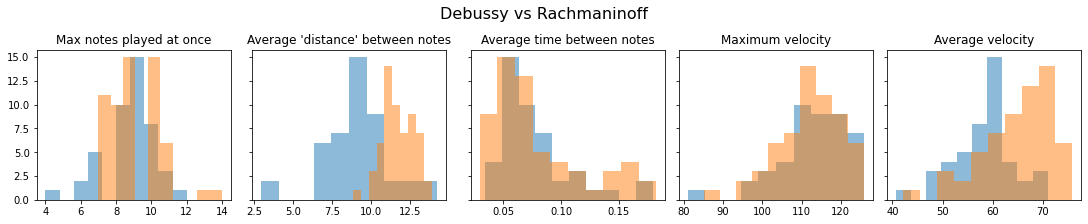

In [ ]:
fig, axs = plt.subplots(1, 5,figsize=(15, 3), sharey = True, constrained_layout = True)

plotTitles = ["Max notes played at once", "Average 'distance' between notes", "Average time between notes","Maximum velocity","Average velocity"]

for i in range(0,5):
  axs[i].hist(debussy_features[:,i], alpha = 0.5)
  axs[i].hist(rachman_features[:,i], alpha = 0.5)
  axs[i].set_title(plotTitles[i])

fig.suptitle('Debussy vs Rachmaninoff', fontsize = 16)
plt.show()

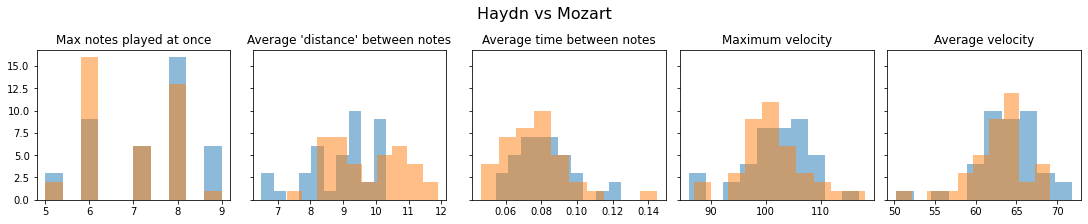

In [ ]:
fig, axs = plt.subplots(1, 5,figsize=(15, 3), sharey = True, constrained_layout = True)

plotTitles = ["Max notes played at once", "Average 'distance' between notes", "Average time between notes","Maximum velocity","Average velocity"]

for i in range(0,5):
  axs[i].hist(haydn_features[:,i], alpha = 0.5)
  axs[i].hist(mozart_features[:,i], alpha = 0.5)
  axs[i].set_title(plotTitles[i])

fig.suptitle('Haydn vs Mozart', fontsize = 16)
plt.show()